In [1]:
import sqlutil
from astropy.table import Table
from os import path
import pickle
import numpy as np
import importlib
import astropy.coordinates as coord
import astropy.units as u
import healpy as hp

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
from gala.coordinates.reflex import reflex_correct
from astropy_healpix import HEALPix
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
from xdgmm import XDGMM
import pandas as pd

In [3]:
def queryDatabase(query, columns, post_query, cache_file='db.pickle'):

    #cache_file = "reducedPM2.pickle"

    if not path.exists(cache_file):
        res = sqlutil.get(query.format(','.join(columns), post_query),
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)

        with open(cache_file, "wb") as f:
            pickle.dump(res, f)
        
    else:
        with open(cache_file, "rb") as f:
            res = pickle.load(f)
    return res

In [4]:
def calc_distance(g, ebv):
    Ag = 2.5*ebv
    gmag = g-Ag
    dist = 10.*10.**(0.2*(gmag-0.5))*1e-3
    return dist

In [5]:
columns = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', \
           'parallax_error', 'int_average_g', \
           'int_average_g_error', 'g_absorption', 'g_absorption_error', \
           'pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'ebv', 'peak_to_peak_g', 'num_clean_epochs_g']
query = """select {0} from gaia_dr2.gaia_source as gs, gaia_DR2.vari_rrlyrae as rr {1}"""
cuts = "WHERE gs.source_id=rr.source_id"

In [6]:
res = queryDatabase(query, columns, cuts, cache_file='gaiaRRlyrae.pkl')
data = Table(res)


In [7]:
data.keys()

['ra',
 'dec',
 'pmra',
 'pmdec',
 'parallax',
 'parallax_error',
 'int_average_g',
 'int_average_g_error',
 'g_absorption',
 'g_absorption_error',
 'pmra_error',
 'pmdec_error',
 'pmra_pmdec_corr',
 'ebv',
 'peak_to_peak_g',
 'num_clean_epochs_g']

Text(0.5,1,'dust values')

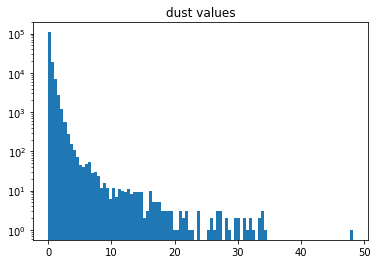

In [8]:
plt.hist(data['ebv'], bins=100, log=True)
plt.title('dust values')

/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


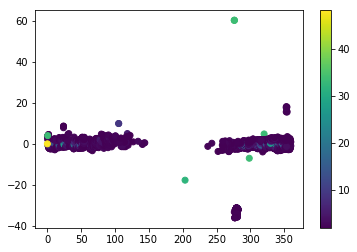

In [11]:
distances = calc_distance(data['int_average_g'], data['ebv'])
c = coord.SkyCoord(ra=data['ra']*u.deg, 
                   dec=data['dec']*u.deg, 
                   pm_ra_cosdec=data['pmra']*u.mas/u.yr,
                   pm_dec=data['pmdec']*u.mas/u.yr,
                   distance = distances*u.kpc, radial_velocity=0.*u.km/u.s)
cCorrect = reflex_correct(c)
cGal = cCorrect.transform_to(coord.Galactic)
highDust = data['ebv'] > 2
plt.scatter(cGal.l[highDust], cGal.b[highDust], c=data['ebv'][highDust])
plt.colorbar()

In [12]:
good = ~np.isnan(data['pmra']) & ~np.isnan(data['pmdec'])  & (data['ebv'] <= 2)
data = data[good]

In [13]:
distances = calc_distance(data['int_average_g'], data['ebv'])

In [14]:
c = coord.SkyCoord(ra=data['ra']*u.deg, 
                   dec=data['dec']*u.deg, 
                   pm_ra_cosdec=data['pmra']*u.mas/u.yr,
                   pm_dec=data['pmdec']*u.mas/u.yr,
                   distance = distances*u.kpc, radial_velocity=0.*u.km/u.s)

In [15]:
cCorrect = reflex_correct(c)

In [16]:
cGal = cCorrect.transform_to(coord.Galactic)

In [17]:
vl = (cGal.pm_l_cosb*cGal.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vb = (cGal.pm_b*cGal.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vra = (cCorrect.pm_ra_cosdec*cCorrect.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vdec = (cCorrect.pm_dec*cCorrect.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vra_no = (c.pm_ra_cosdec*cCorrect.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vdec_no = (c.pm_dec*cCorrect.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())

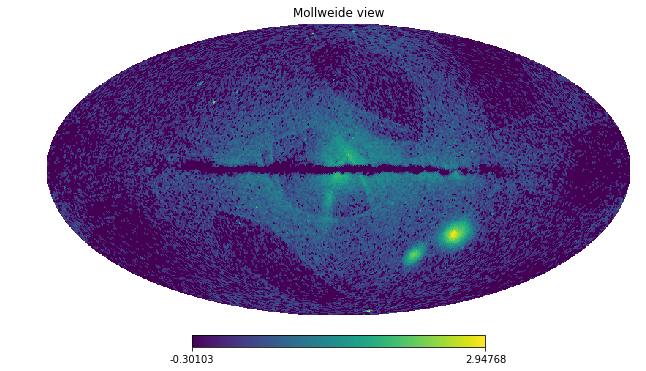

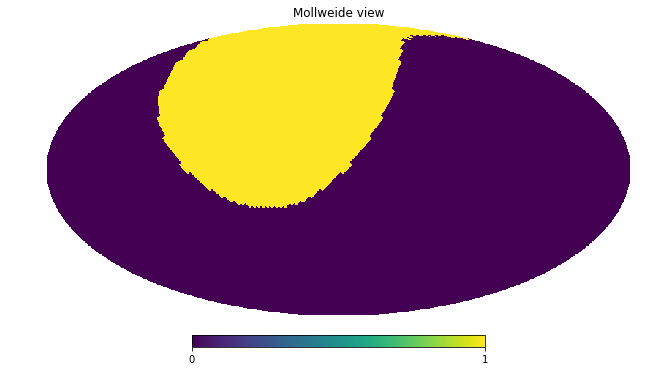

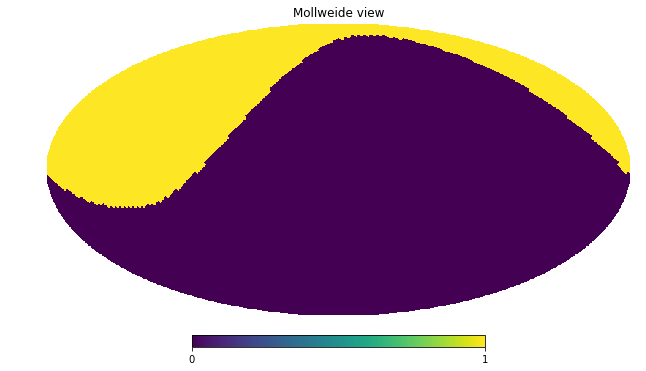

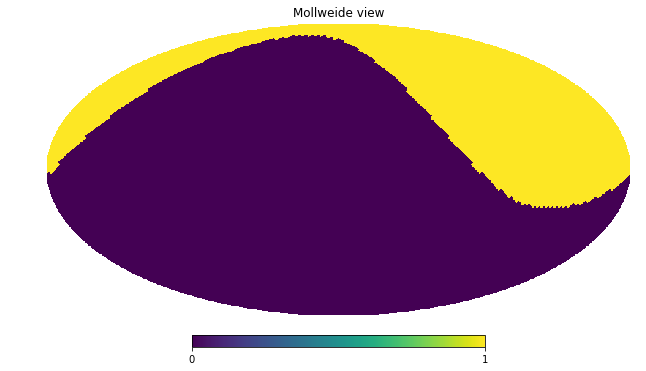

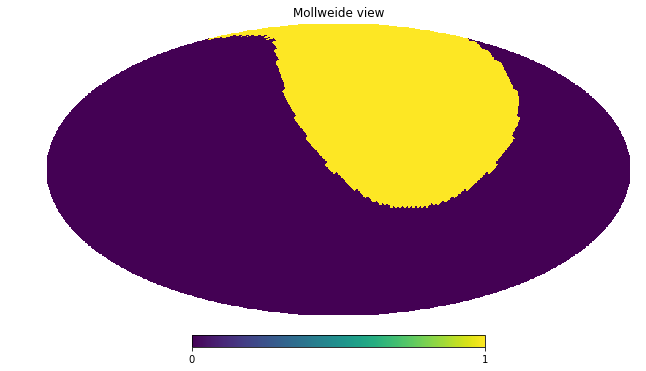

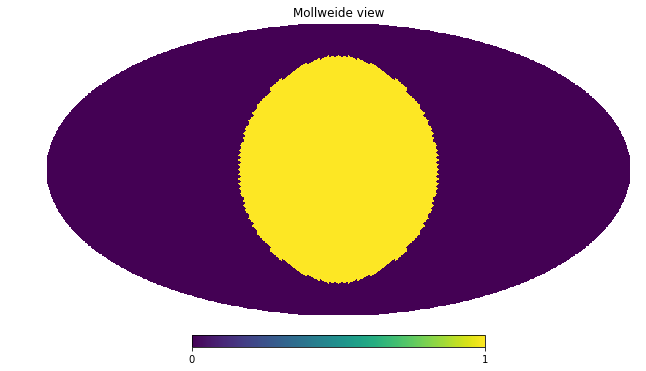

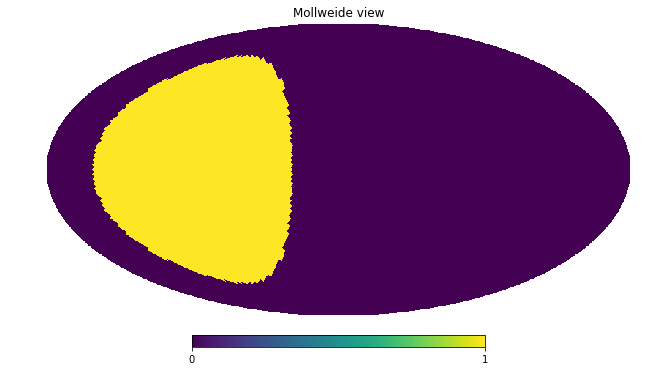

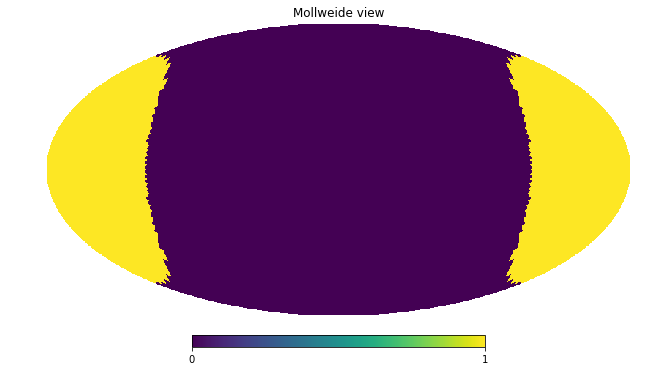

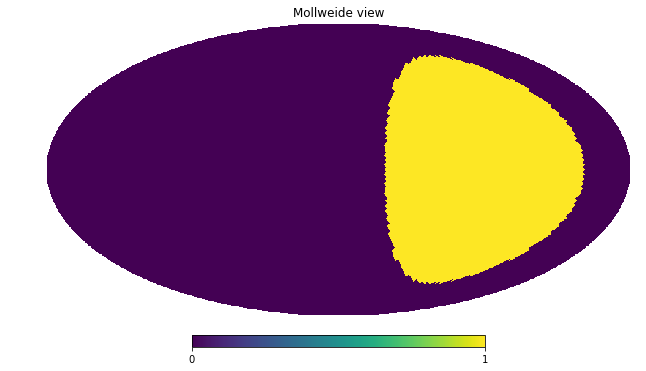

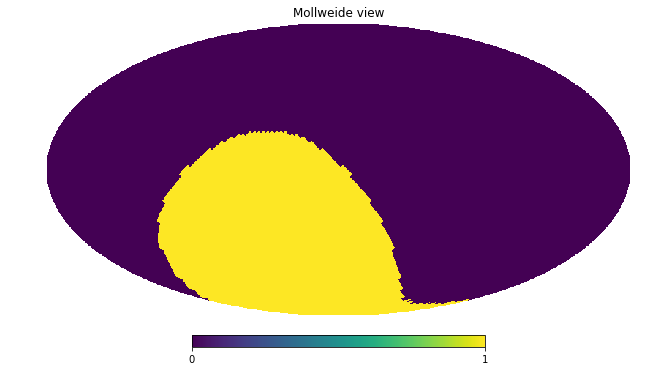

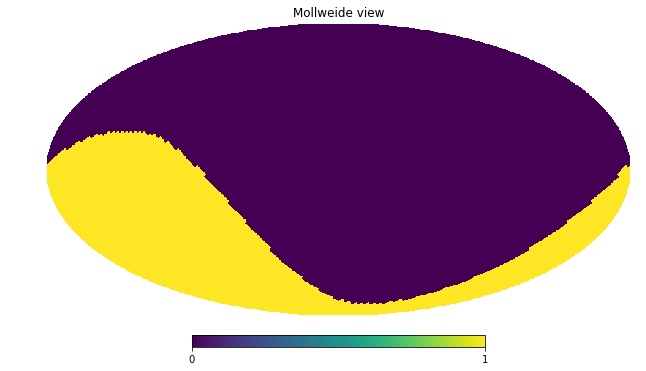

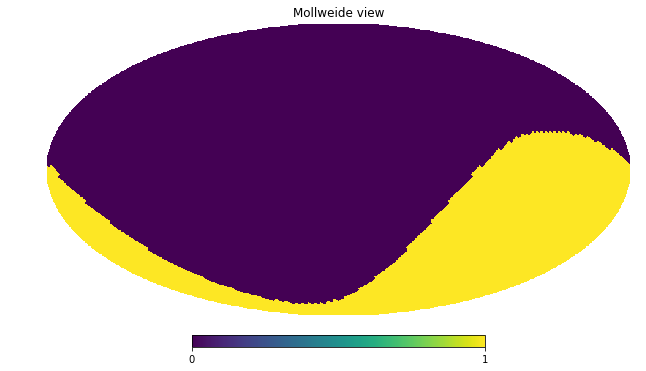

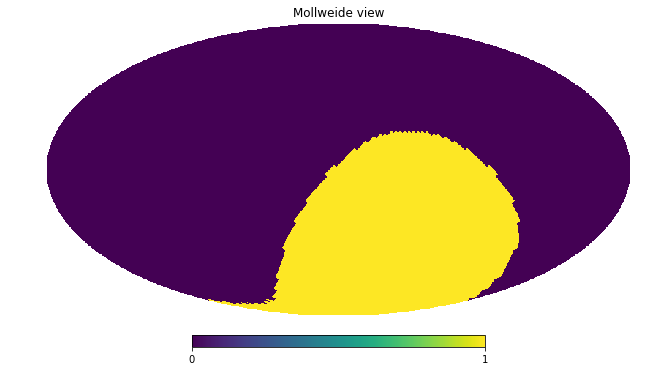

In [20]:
nside = 64
hpixMap = HEALPix(order="ring", nside=nside, frame=coord.Galactic())
pixnums_m = hpixMap.skycoord_to_healpix(cGal)
omap = np.bincount(pixnums_m, minlength=hpixMap.npix)
mapSky = hp.mollview(np.log10(omap+0.5), return_projected_map=True)


#pixelize sky

hpixSearch = HEALPix(nside=1, frame=coord.Galactic(), order='ring')
hpix = HEALPix(nside=32, frame=coord.Galactic(), order='ring')
pixel_index = hpix.skycoord_to_healpix(cGal)
lim = 200
nbins = 128
#dmins = np.array([0, 5, 10, 15, 20])*u.kpc
#dmaxs = np.array([10, 15, 20, 25, 1000])*u.kpc
dmins = [0*u.kpc]
dmaxs = [1000*u.kpc]
vmax = 10
#grab all pixels with some radius around each pixel
for pixnumber in range(hpixSearch.npix):
    pixcoord = hpixSearch.healpix_to_skycoord(pixnumber)
    pixels = hpix.cone_search_skycoord(pixcoord, radius=60 * u.deg)        
    indices_pix = np.array([np.array(pixel_index == p).astype(np.bool_) for p in pixels]).any(axis=0)
    for dmin, dmax in zip(dmins, dmaxs):
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        indices = indices_pix & (cGal.distance >= dmin) & (cGal.distance < dmax)
        xbins = np.linspace(-lim, lim, nbins)
        ybins = xbins
        H, xe, ye = np.histogram2d(vl[indices], vb[indices], bins=(xbins, ybins))
        smooth = gaussian_filter(H, sigma=0.75)
        im = ax[0].pcolormesh(xe, ye, smooth.T,
                  cmap='inferno', vmin=1, vmax=vmax)#, vmax=20) #, vmin=-100, vmax=100)
        fig.colorbar(im, ax=ax[0])
        mask = np.zeros(hpix.npix)
        mask[pixels] = 1.0
        piximg = hp.mollview(mask, return_projected_map=True) #,rot=(0, 90, 0))
        im2 = ax[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90], cmap='inferno', vmax=1)
        im3 = ax[1].imshow(piximg, origin='lower', extent=[-180, 180, -90, 90], cmap='gist_gray', vmax=0.5, alpha=0.5)
        ax[0].set_xlabel('$v_l$ [km/s]')
        ax[0].set_ylabel('$v_b$ [km/s]')
        ax[1].set_xlabel('l')
        ax[1].set_ylabel('b')

        #im = ax.scatter(vl[indices], vb[indices], s=1)
        #ax.set_xlim(-lim, lim)
        #ax.set_ylim(-lim, lim)
        #im.set_rasterized(True)
        im2.set_rasterized(True)
        im3.set_rasterized(True)
        fig.savefig('vlvb_{0:03d}_{1:02d}.png'.format(pixnumber, np.int(dmin.value)))
        plt.close(fig)
        #plt.xlim(0, 360)
        #plt.ylim(-90, 90)

In [31]:
xdgmm = XDGMM(n_components =10, method='Bovy')

In [32]:
X = pd.DataFrame(data={'l':cGal.l.value, 
                       'b':cGal.b.value,
                       'vl':vl,
                       'vb':vb,
                       'distance':distances})


In [24]:
v_err = np.sqrt(data['pmra_error']**2 + data['pmdec_error']**2)

In [25]:
dminus = calc_distance(data['int_average_g'] + data['int_average_g_error'], data['ebv'])
dplus = calc_distance(data['int_average_g'] - data['int_average_g_error'], data['ebv'])

In [26]:
d_err = 0.5*((dminus - distances) + (distances - dplus))

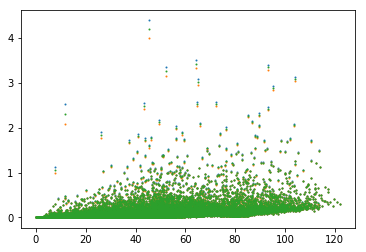

In [27]:
plt.scatter(distances, dminus - distances, s=1)
plt.scatter(distances, distances - dplus, s=1)
plt.scatter(distances, d_err, s=1)
#plt.scatter(distances, dplus, s=1)

In [28]:
Xerr = pd.DataFrame(data={'l_err':np.zeros(len(cGal)),
                          'b_err':np.zeros(len(cGal)),
                          'vl_err':v_err, 
                          'vb_err':v_err,
                          'd_err':d_err})

In [33]:
xdgmm.fit(X[['l', 'b', 'vl', 'vb', 'distance']], Xerr[['l_err', 'b_err', 'vl_err', 'vb_err', 'd_err']])

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

TypeError: 'module' object is not callable

Text(0.5,1,'RR lyrae Distances')

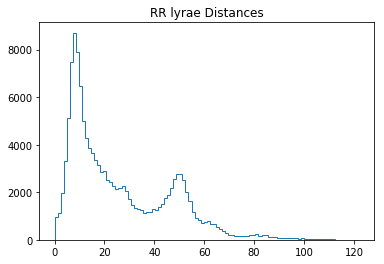

In [64]:
plt.hist(distances, bins=100, histtype='step')
plt.title('RR lyrae Distances')

Text(0,0.5,'proper motion')

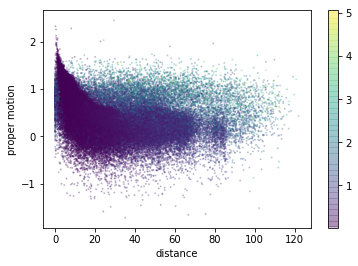

In [116]:
plt.scatter(distances, np.log10(np.sqrt(data['pmra']**2 + data['pmdec']**2)), s=1, alpha=0.25, c=data['pmra_error'])
plt.colorbar()
plt.xlabel('distance')
plt.ylabel('proper motion')

Text(0.5,1,'RR lyrae velocities')

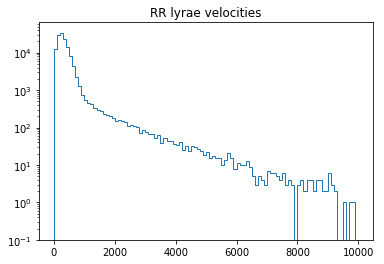

In [73]:
plt.hist(np.sqrt(vra_no.value**2. + vdec_no.value**2.), bins=100, histtype='step', range=[0, 1e4], log=True)
plt.title('RR lyrae velocities')

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5,1,'RR lyrae velocities')

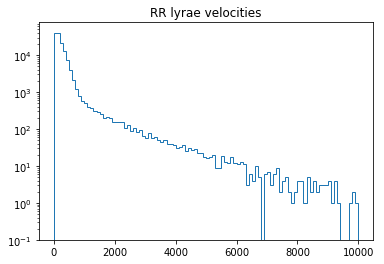

In [74]:
plt.hist(np.sqrt(vra.value**2. + vdec.value**2.), bins=100, histtype='step', range=[0, 1e4], log=True)
plt.title('RR lyrae velocities')

In [75]:
import matplotlib as mpl

In [76]:
v_tan = np.sqrt(vl.value**2. + vb.value**2)

In [77]:
select = v_tan > 8000
snpmra = c.pm_ra_cosdec[select]/data['pmra_error'][select]
snpmdec = data['pmdec'][select]/data['pmdec_error'][select]
print(snpmra, snpmdec, c.pm_ra_cosdec[select], c.pm_dec[select])

[ -9.24057752  -3.75203313  -3.22660898 -19.48504205   1.53833229
  22.41780932  -3.66319472  11.30683432  -2.00555813  11.8490169
  -7.08295907  -2.05531851   5.35750641  23.77952497  -7.30021124
   6.24496479  -6.52780429 -10.92852469   6.40605464   4.02387322
  54.00336074   5.18974013   0.64837167  -5.82563821 -94.50063232
 -22.7177571  -10.43044956   7.54989816   5.58778961  13.1257628
   5.35451296  -0.76033469   8.94871357  22.79746949   6.30031178
  18.13846973  -1.23454901  -9.78617699  -1.44168775  44.07401599
  90.58775264   8.67682345  27.21194405  14.23205556  11.39167311
  10.17951191  17.68140188 -36.73814117  -7.57649523   0.90156638
 -10.54740399  -7.23459003   2.19839536  -8.04937725  -2.20112563
  -2.35255862 -15.00597347  -6.35864643  10.57875736   6.95315367
   0.90149615  -6.35340073   3.79215299  15.0052677   -7.85631434
 -10.97708586  -6.92707622 -25.19408175  -6.66423661 -18.94587891
 -10.20292366 -12.00228762  10.51391816 -11.48853212 -26.40942665
 -24.2700601

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


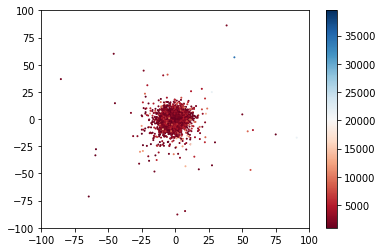

In [78]:
select = v_tan > 1000
plt.scatter(c.pm_ra_cosdec[select]/data['pmra_error'][select], 
            data['pmdec'][select]/data['pmdec_error'][select], s=1, c=v_tan[select], cmap='RdBu')
lim = 100
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.colorbar()

Text(0.5,1,'RR lyrae Velocity on Sky')

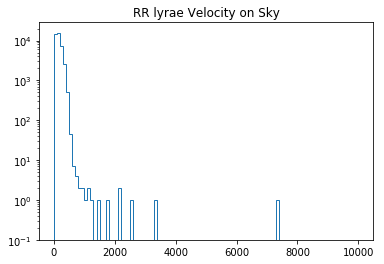

In [79]:
sig = 5
interesting = (np.abs(data['pmra']/data['pmra_error']) > sig) & \
              (np.abs(data['pmdec']/data['pmdec_error']) > sig) & \
              (v_tan > 2000) & \
              (data['int_average_g'] < 17)

select = (np.abs(data['pmra']/data['pmra_error']) > sig) & (np.abs(data['pmdec']/data['pmdec_error']) > sig) & (data['int_average_g'] < 17)
plt.hist(np.sqrt(vl[select].value**2. + vb[select].value**2), bins=100, histtype='step', range=[0, 10000], log=True)
plt.title('RR lyrae Velocity on Sky')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


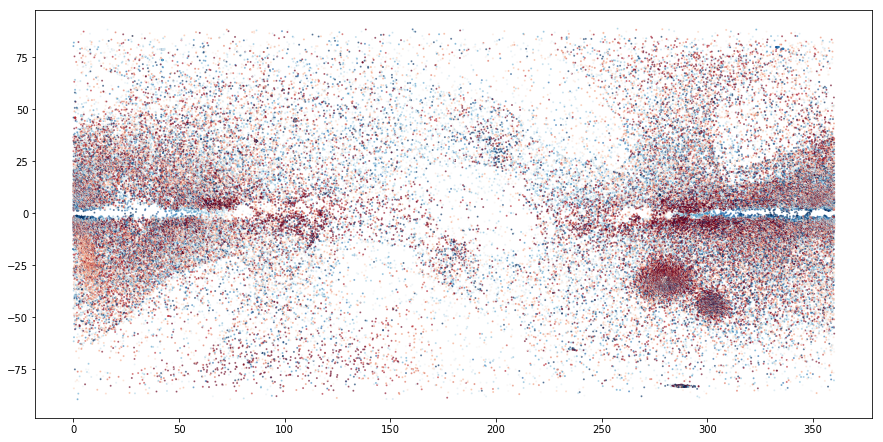

In [148]:
plt.figure(figsize=(15, 7.5))
plt.scatter(cGal.l, cGal.b, s=1, alpha=0.5, c=vl.value, vmax=200, vmin=-200, cmap='RdBu')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


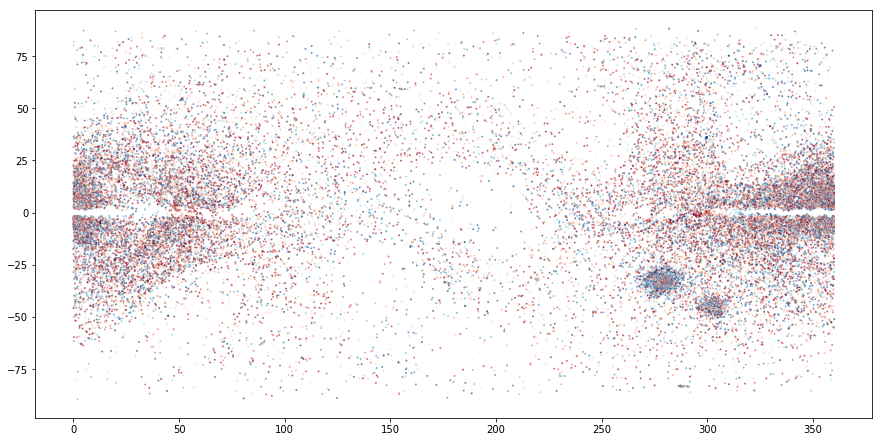

In [163]:
v1 = 200
v2 = 100
select = (v_tan < v1 ) & (v_tan > v2)
plt.figure(figsize=(15, 7.5))
plt.scatter(cGal[select].l, cGal[select].b, s=1, alpha=0.5, c=v_tan[select], cmap='RdBu')

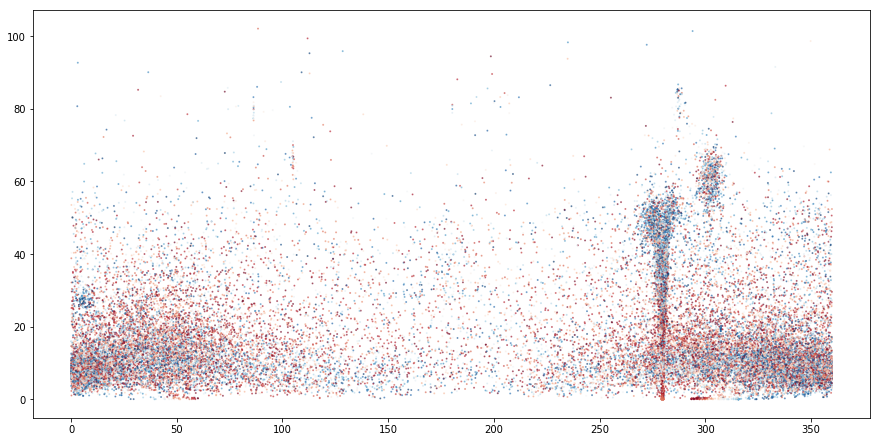

In [164]:
plt.figure(figsize=(15, 7.5))
plt.scatter(cGal[select].l, cGal[select].distance, s=1, alpha=0.5, c=v_tan[select], cmap='RdBu')
#plt.colorbar()

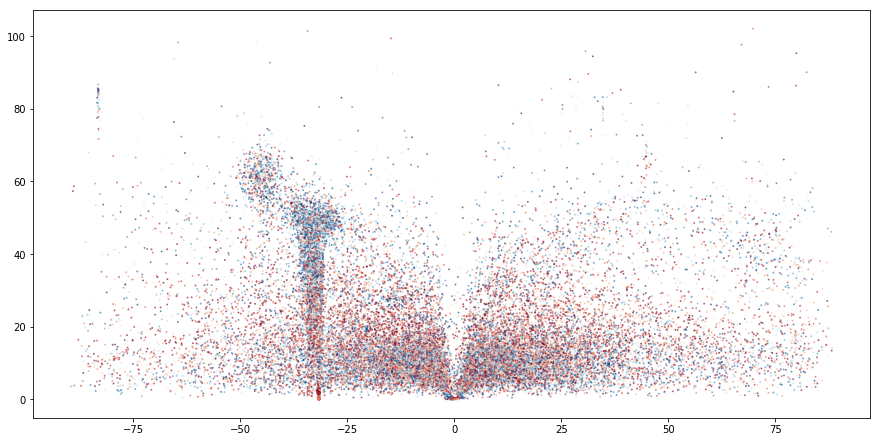

In [165]:
plt.figure(figsize=(15, 7.5))
plt.scatter(cGal[select].b, cGal[select].distance, s=1, alpha=0.5, c=v_tan[select], cmap='RdBu')
#plt.colorbar()

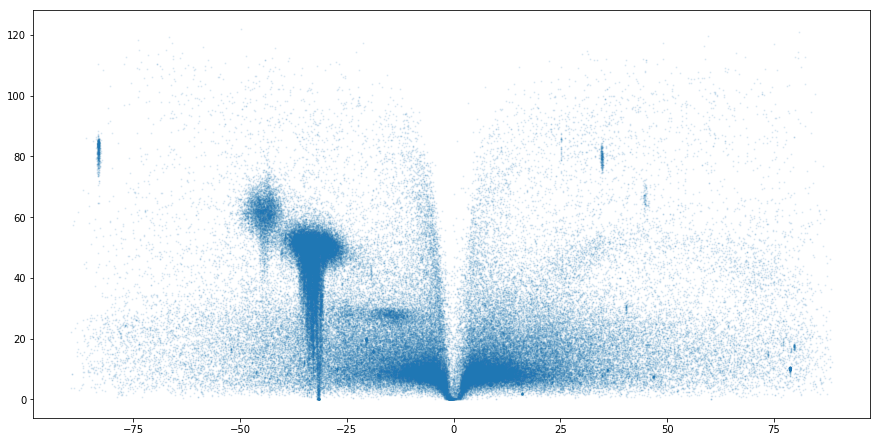

In [124]:
plt.figure(figsize=(15, 7.5))
plt.scatter(cGal.b, cGal.distance, s=1, alpha=0.1)

In [102]:
lmc = (np.abs(cGal.l - 280*u.deg).value < 10) & (np.abs(cGal.b + 35*u.deg).value < 10)

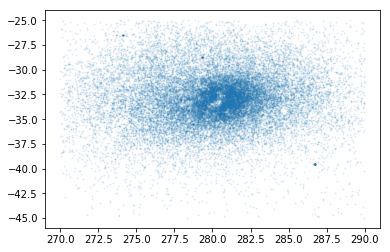

In [103]:
plt.scatter(cGal[lmc].l, cGal[lmc].b, s=1, alpha=0.1)

(-10, 10)

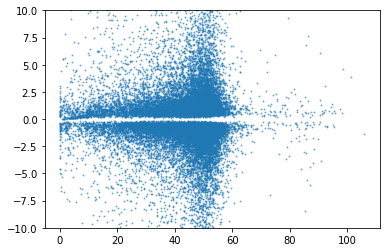

In [115]:
plt.scatter(distances[lmc], data['parallax_error'][lmc]/data['parallax'][lmc], s=1, alpha=0.5)
plt.ylim(-10, 10)

(0, 100)

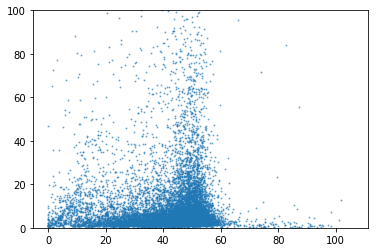

In [104]:
plt.scatter(distances[lmc], 1./data['parallax'][lmc], s=1, alpha=0.5)
plt.ylim(0, 100)

In [106]:
data[interesting]

ra,dec,pmra,pmdec,parallax,parallax_error,int_average_g,int_average_g_error,g_absorption,g_absorption_error,pmra_error,pmdec_error,pmra_pmdec_corr,ebv,peak_to_peak_g,num_clean_epochs_g
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,int32
38.2337922286941,4.40488323607676,-28.639983431891,-9.76512923725761,2.68116959736402,0.394979591857905,16.8011443322951,0.00218594519249301,nan,nan,0.908386850957702,0.623222519433516,-0.235332,0.052554,0.622223264703742,16
181.926442489243,-26.6156183627833,-35.7172865679639,25.0359788023529,1.50997668718284,0.1443079949111,16.7414962166691,0.0180811670584554,nan,nan,0.210830430448516,0.164341938075428,-0.284731,0.080629,0.24291700463106,28
265.191096709516,6.06403324240826,14.1580862731247,-45.3902488552695,4.14049315760422,0.0744621267134753,15.8497540817255,0.000793630499176353,0.271869045267791,0.0515507104448254,0.129209024443079,0.0991454455300257,-0.0710875,0.155894,0.267562650096053,27
105.871422861466,-84.413077083078,18.2727449736993,26.7774269763482,2.09879093959647,0.187501624060258,16.9337532365943,0.00180258120140547,nan,nan,0.477649629209509,0.310879908612882,0.133763,0.220485,0.524813600210454,18
247.356004921696,-57.3857021648357,-79.5834459034784,173.42651583774,-7.46156222924633,0.392337431100863,15.9311292250416,0.000551700031961951,nan,nan,0.385881487692399,0.489788960848918,-0.468049,0.362222,0.82941648640754,27


In [108]:
v_tan[interesting]

array([2560.40365454, 3306.16762548, 2101.56130253, 2165.62346875,
       7345.90344388])

In [126]:
distances[interesting]

17.137673585853186
16.143018511874207
9.81756577613148
15.014405795448976
8.037386534743224


In [127]:
data['ebv'][interesting]

0.052554
0.080629
0.155894
0.220485
0.362222


In [82]:
cGal[interesting]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [(164.65682368, -50.06133244, 17.13767359),
     (290.95013045,  35.2365857 , 16.14301851),
     ( 30.29715556,  18.46809136,  9.81756578),
     (296.68452171, -26.69653802, 15.0144058 ),
     (329.11472184,  -6.05621696,  8.03738653)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-20.02943289, -24.33307483,   27.00603225),
     (-38.89993789,  18.79720928, -169.71008581),
     (-30.05027144, -33.70546021,  122.50656485),
     (-23.17412311,  19.71643239, -184.21386504),
     ( 77.22591391, 176.65877021, -109.86448283)]>

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


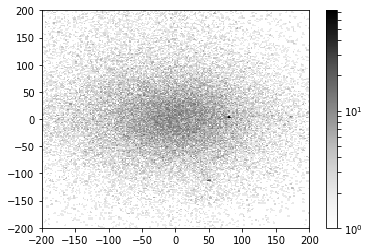

In [126]:
max = 200
xbins = np.linspace(-max, max, 200)
ybins = xbins
H, xe, ye = np.histogram2d(vl, vb, bins=(xbins, ybins))


im = plt.pcolormesh(xe, ye, H.T,
              cmap='Greys', norm=mpl.colors.LogNorm()) #, vmin=-100, vmax=100)
plt.colorbar(im)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


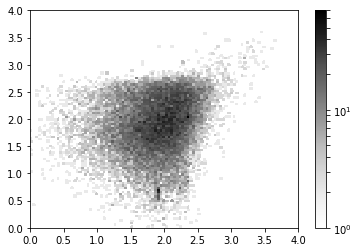

In [135]:
max = 4
xbins = np.linspace(0, max, 100)
ybins = xbins
H, xe, ye = np.histogram2d(np.log10(vl.value), np.log10(vb.value), bins=(xbins, ybins))


im = plt.pcolormesh(xe, ye, H.T,
              cmap='Greys', norm=mpl.colors.LogNorm()) #, vmin=-100, vmax=100)
plt.colorbar(im)


In [89]:
%%timeit -n1 -r1
foo = MC_error_propagation.MCvs(data['ra'],data['dec'],
                           data['pmra'], data['pmra_error'], 
                           data['pmdec'], data['pmdec_error'],
                           data['pmra_pmdec_corr'], 
                           data['int_average_g'], data['int_average_g_error'], 
                           data['ebv'], 1)

/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/landerson/gaiaDR2/MC_error_propagation.py:84: RuntimeWarning: Degrees of freedom <= 0 for slice
  pm_b_pm_l_cov = np.array([np.cov(np.array([pm_l_i[i], pm_b_i[i]]))[0][1] for i in range(len(pm_b_i))])
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/Users/landerson/gaiaDR2/MC_error_propagation.py:87: RuntimeWarning: Degrees

1min 47s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [93]:
foo = MC_error_propagation.MCvs(data['ra'],data['dec'],
                           data['pmra'], data['pmra_error'], 
                           data['pmdec'], data['pmdec_error'],
                           data['pmra_pmdec_corr'], 
                           data['int_average_g'], data['int_average_g_error'], 
                           data['ebv'], 1)
foo

/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/landerson/gaiaDR2/MC_error_propagation.py:84: RuntimeWarning: Degrees of freedom <= 0 for slice
  pm_b_pm_l_cov = np.array([np.cov(np.array([pm_l_i[i], pm_b_i[i]]))[0][1] for i in range(len(pm_b_i))])
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/Users/landerson/gaiaDR2/MC_error_propagation.py:87: RuntimeWarning: Degrees

(-2.475807578180254,
 0.3614048967983881,
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 87.90654896019278,
 -185.63350589831302,
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([-3., -3., -3., ..., -3., -3., -3.]),
 array([-3., -3., -3., ..., -3., -3., -3.]),
 array([-3., -3., -3., ..., -3., -3., -3.]),
 array([-3., -3., -3., ..., -3., -3., -3.]))

In [92]:
len(data)

135825

In [98]:
foo[2].max()

0.0